In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import cv2
import os
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import seaborn as sns
from skimage.feature import hog
import pickle
import warnings
warnings.filterwarnings('ignore')

In [4]:
DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/data_use'

IMG_SIZE = (64, 64)
RANDOM_STATE = 42

# Class mapping (Giữ nguyên)
CLASS_MAP = {
    '10': 'cấm xe ô tô tải vượt',
    '12': 'bắt đầu đường ưu tiên',
    '14': 'stop',
    '15': 'đường cấm',
    '16': 'cấm ô tô tải',
    '17': 'cấm đi ngược chiều',
    '21': 'cảnh báo đường gấp khúc',
    '22': 'đường có gồ giảm sóc',
    '40': 'vòng xuyến'
}

In [5]:
def extract_hog_features(image, orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2)):
    """Trích xuất đặc trưng HOG (Histogram of Oriented Gradients)"""
    features = hog(image,
                   orientations=orientations,
                   pixels_per_cell=pixels_per_cell,
                   cells_per_block=cells_per_block,
                   block_norm='L2-Hys',
                   visualize=False,
                   feature_vector=True)
    return features

def extract_color_histogram(image, bins=(8, 8, 8)):
    """Trích xuất đặc trưng Color Histogram từ ảnh HSV"""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    hist_h = cv2.calcHist([hsv], [0], None, [bins[0]], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [bins[1]], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [bins[2]], [0, 256])

    hist_h = cv2.normalize(hist_h, hist_h).flatten()
    hist_s = cv2.normalize(hist_s, hist_s).flatten()
    hist_v = cv2.normalize(hist_v, hist_v).flatten()

    color_features = np.concatenate([hist_h, hist_s, hist_v])
    return color_features

def extract_combined_features(image):
    """Kết hợp đặc trưng HOG và Color Histogram"""
    # Chuyển sang Grayscale cho HOG
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Trích xuất HOG (hình dạng)
    hog_features = extract_hog_features(gray)

    # Trích xuất Color (màu sắc)
    color_features = extract_color_histogram(image)

    # Kết hợp
    combined_features = np.concatenate([hog_features, color_features])
    return combined_features

In [6]:
def load_dataset(data_path, img_size=IMG_SIZE, max_images_per_class=None):
    """Tải ảnh từ các thư mục và trích xuất đặc trưng"""
    X = []
    y = []
    label_names = {}

    data_dir = Path(data_path)

    for idx, class_folder in enumerate(sorted(CLASS_MAP.keys())):
        folder_path = data_dir / class_folder

        if not folder_path.exists():
            print(f"Cảnh báo: Không tìm thấy {folder_path}. Bỏ qua...")
            continue

        label_names[idx] = CLASS_MAP[class_folder]
        print(f"Đang tải lớp {idx}: {CLASS_MAP[class_folder]} từ {class_folder}/")

        image_files = list(folder_path.glob('*.jpg')) + \
                     list(folder_path.glob('*.png')) + \
                     list(folder_path.glob('*.jpeg'))

        if max_images_per_class:
            image_files = image_files[:max_images_per_class]

        count = 0
        for img_path in image_files:
            try:
                img = cv2.imread(str(img_path))
                if img is None: continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, img_size)

                # Gọi hàm trích xuất đặc trưng đã đơn giản hóa
                features = extract_combined_features(img)

                X.append(features)
                y.append(idx)
                count += 1

            except Exception as e:
                print(f"Lỗi xử lý {img_path}: {e}")

        print(f"  Đã tải {count} ảnh")

    return np.array(X), np.array(y), label_names

In [7]:
print("[Bước 1] Đang tải dữ liệu và trích xuất đặc trưng...")
X, y, label_names = load_dataset(DATA_PATH, img_size=IMG_SIZE)

print("\nHoàn tất tải dữ liệu!")
print(f"Tổng số mẫu: {len(X)}")
print(f"Số chiều đặc trưng: {X.shape[1]}")
print(f"Số lượng lớp: {len(label_names)}")

print("\n[Bước 2] Chia dữ liệu Train/Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Số mẫu huấn luyện: {len(X_train)}")
print(f"Số mẫu kiểm tra: {len(X_test)}")

[Bước 1] Đang tải dữ liệu và trích xuất đặc trưng...
Đang tải lớp 0: cấm xe ô tô tải vượt từ 10/
  Đã tải 2010 ảnh
Đang tải lớp 1: bắt đầu đường ưu tiên từ 12/
  Đã tải 2100 ảnh
Đang tải lớp 2: stop từ 14/
  Đã tải 780 ảnh
Đang tải lớp 3: đường cấm từ 15/
  Đã tải 630 ảnh
Đang tải lớp 4: cấm ô tô tải từ 16/
  Đã tải 420 ảnh
Đang tải lớp 5: cấm đi ngược chiều từ 17/
  Đã tải 1110 ảnh
Đang tải lớp 6: cảnh báo đường gấp khúc từ 21/
  Đã tải 330 ảnh
Đang tải lớp 7: đường có gồ giảm sóc từ 22/
  Đã tải 390 ảnh
Đang tải lớp 8: vòng xuyến từ 40/
  Đã tải 360 ảnh

Hoàn tất tải dữ liệu!
Tổng số mẫu: 8130
Số chiều đặc trưng: 1788
Số lượng lớp: 9

[Bước 2] Chia dữ liệu Train/Test...
Số mẫu huấn luyện: 6504
Số mẫu kiểm tra: 1626


In [8]:
def train_model(pipeline, param_grid, X_train, y_train):
    """
    Hàm huấn luyện chung sử dụng RandomizedSearchCV để tìm tham số tốt nhất.
    Nhanh hơn GridSearchCV và khắc phục lỗi 'treo'.
    """

    # n_iter: Số lượng kết hợp tham số ngẫu nhiên để thử
    # n_jobs=1: Sửa lỗi 'treo' trên Windows. Chỉ dùng 1 lõi CPU.

    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_grid,
        n_iter=10,
        cv=5,
        scoring='accuracy',
        n_jobs=1,
        verbose=2,  # <<<--- THAY ĐỔI Ở ĐÂY (từ 1 thành 2)
        random_state=RANDOM_STATE
    )

    print("Bắt đầu tìm kiếm tham số tối ưu...")
    random_search.fit(X_train, y_train)

    print(f"\nTham số tốt nhất: {random_search.best_params_}")
    print(f"Điểm CV tốt nhất: {random_search.best_score_:.4f}")

    return random_search.best_estimator_

In [9]:
print("\n" + "="*70)
print("HUẤN LUYỆN SVM")
print("="*70)

# 1. Tạo pipeline
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=RANDOM_STATE, probability=True))
])

# 2. Định nghĩa lưới tham số
svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 'auto', 0.001, 0.01],
    'svm__kernel': ['rbf', 'linear']
}

# 3. Huấn luyện
best_svm_model = train_model(svm_pipeline, svm_param_grid, X_train, y_train)


HUẤN LUYỆN SVM
Bắt đầu tìm kiếm tham số tối ưu...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...svm__C=100, svm__gamma=0.001, svm__kernel=linear; total time=  25.4s
[CV] END ...svm__C=100, svm__gamma=0.001, svm__kernel=linear; total time=  26.0s
[CV] END ...svm__C=100, svm__gamma=0.001, svm__kernel=linear; total time=  24.0s
[CV] END ...svm__C=100, svm__gamma=0.001, svm__kernel=linear; total time=  25.2s
[CV] END ...svm__C=100, svm__gamma=0.001, svm__kernel=linear; total time=  25.3s
[CV] END ......svm__C=1, svm__gamma=0.01, svm__kernel=linear; total time=  25.1s
[CV] END ......svm__C=1, svm__gamma=0.01, svm__kernel=linear; total time=  25.2s
[CV] END ......svm__C=1, svm__gamma=0.01, svm__kernel=linear; total time=  24.9s
[CV] END ......svm__C=1, svm__gamma=0.01, svm__kernel=linear; total time=  25.4s
[CV] END ......svm__C=1, svm__gamma=0.01, svm__kernel=linear; total time=  25.4s
[CV] END ......svm__C=100, svm__gamma=scale, svm__kernel=rbf; total time= 1.3m

In [10]:
import joblib

# Lưu mô hình SVM tốt nhất
joblib.dump(best_svm_model, "best_svm_model.pkl")

print("Đã lưu mô hình: best_svm_model.pkl")

Đã lưu mô hình: best_svm_model.pkl


In [ ]:
print("\n" + "="*70)
print("HUẤN LUYỆN RANDOM FOREST")
print("="*70)

# 1. Tạo pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()), # Không bắt buộc cho RF nhưng giữ cho nhất quán
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE))
])

# 2. Định nghĩa lưới tham số
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

# 3. Huấn luyện
best_rf_model = train_model(rf_pipeline, rf_param_grid, X_train, y_train)


HUẤN LUYỆN RANDOM FOREST
Bắt đầu tìm kiếm tham số tối ưu...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=200; total time=  45.8s
[CV] END rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=200; total time=  46.3s
[CV] END rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=200; total time=  45.7s
[CV] END rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=200; total time=  46.2s
[CV] END rf__max_depth=20, rf__min_samples_leaf=4, rf__min_samples_split=5, rf__n_estimators=200; total time=  45.9s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=  24.4s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf__min_samples_split=2, rf__n_estimators=100; total time=  23.6s
[CV] END rf__max_depth=None, rf__min_samples_leaf=2, rf

In [ ]:
import joblib

# Lưu mô hình SVM tốt nhất
joblib.dump(best_rf_model, "best_rf_model.pkl")

print("Đã lưu mô hình: best_rf_model.pkl")

In [17]:
def plot_confusion_matrix(y_true, y_pred, label_names, title='Confusion Matrix'):
    """Vẽ ma trận nhầm lẫn"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[label_names[i] for i in range(len(label_names))],
                yticklabels=[label_names[i] for i in range(len(label_names))])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def plot_training_results(results_dict):
    """Vẽ đồ thị so sánh các mô hình"""
    models = list(results_dict.keys())
    accuracies = [results_dict[m]['accuracy'] for m in models]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(models, accuracies, color=['#3498db', '#e74c3c'])
    plt.ylabel('Accuracy')
    plt.title('So sánh Độ chính xác')
    plt.ylim([0, 1.0])

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


[Bước 6] Đánh giá mô hình trên tập Test...

----------------------------------------------------------------------
Báo cáo Phân loại SVM:
                         precision    recall  f1-score   support

   cấm xe ô tô tải vượt       1.00      1.00      1.00       402
  bắt đầu đường ưu tiên       1.00      1.00      1.00       420
                   stop       1.00      0.99      1.00       156
              đường cấm       1.00      1.00      1.00       126
           cấm ô tô tải       1.00      1.00      1.00        84
     cấm đi ngược chiều       1.00      1.00      1.00       222
cảnh báo đường gấp khúc       1.00      1.00      1.00        66
   đường có gồ giảm sóc       1.00      1.00      1.00        78
             vòng xuyến       1.00      1.00      1.00        72

               accuracy                           1.00      1626
              macro avg       1.00      1.00      1.00      1626
           weighted avg       1.00      1.00      1.00      1626


------------

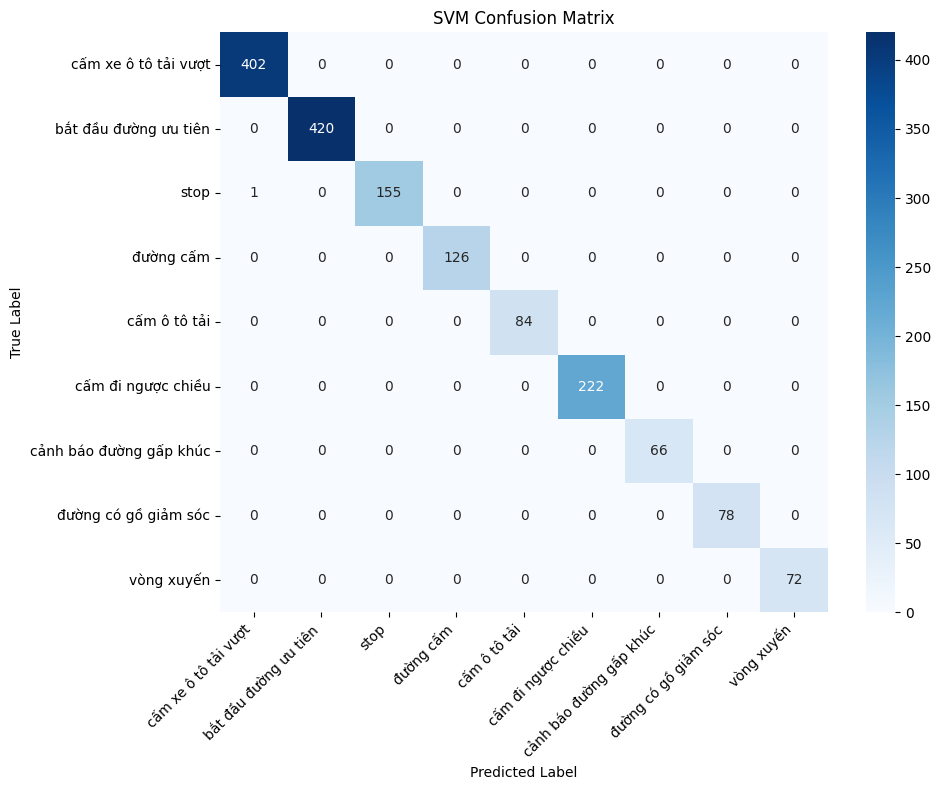

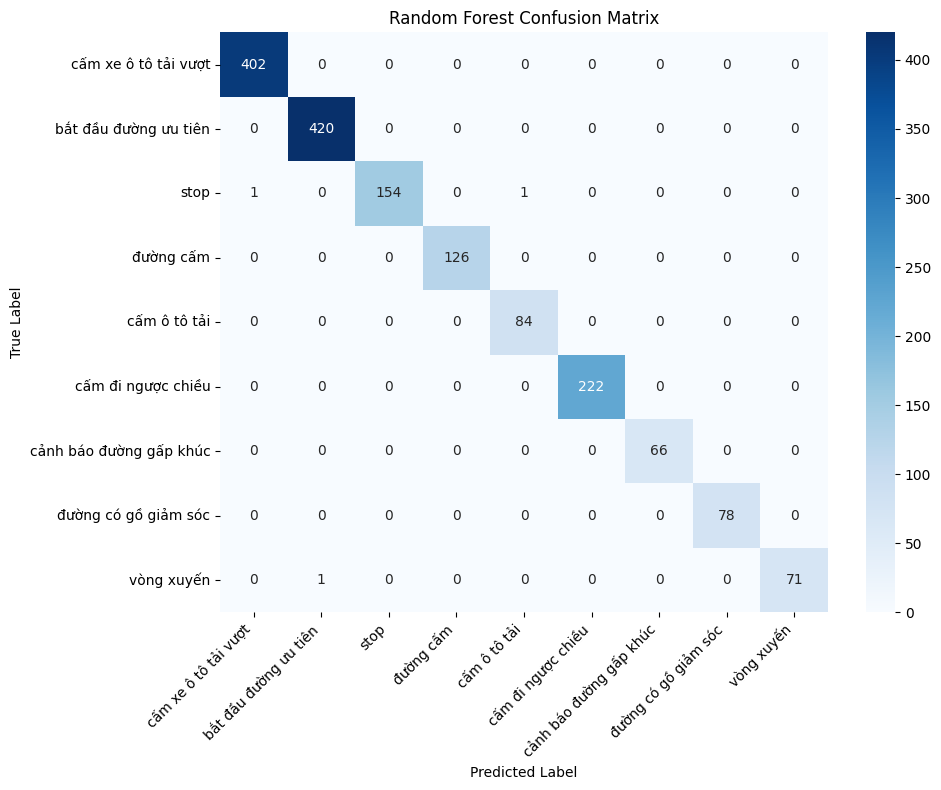


Đang vẽ đồ thị so sánh...


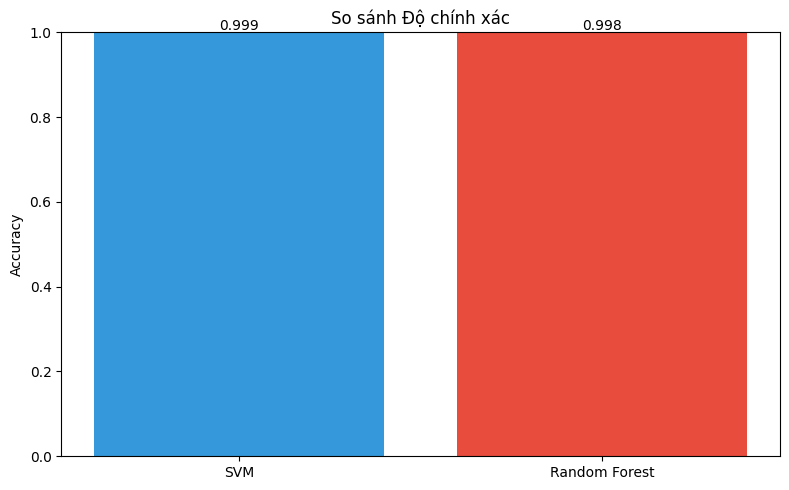

In [18]:
print("\n[Bước 6] Đánh giá mô hình trên tập Test...")
results = {}

# Đánh giá SVM
svm_pred = best_svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
results['SVM'] = {'model': best_svm_model, 'accuracy': svm_acc}

print("\n" + "-"*70)
print("Báo cáo Phân loại SVM:")
print(classification_report(y_test, svm_pred,
                            target_names=[label_names[i] for i in range(len(label_names))]))

# Đánh giá Random Forest
rf_pred = best_rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
results['Random Forest'] = {'model': best_rf_model, 'accuracy': rf_acc}

print("\n" + "-"*70)
print("Báo cáo Phân loại Random Forest:")
print(classification_report(y_test, rf_pred,
                            target_names=[label_names[i] for i in range(len(label_names))]))

# Trực quan hóa
print("\nĐang vẽ ma trận nhầm lẫn...")
plot_confusion_matrix(y_test, svm_pred, label_names, title='SVM Confusion Matrix')
plot_confusion_matrix(y_test, rf_pred, label_names, title='Random Forest Confusion Matrix')

print("\nĐang vẽ đồ thị so sánh...")
plot_training_results(results)

In [19]:
print("\n[Bước 7] Lưu mô hình tốt nhất...")

best_model_name = max(results.keys(), key=lambda k: results[k]['accuracy'])
best_model = results[best_model_name]['model']
best_accuracy = results[best_model_name]['accuracy']

model_data = {
    'model': best_model,
    'label_names': label_names,
    'img_size': IMG_SIZE,
    'feature_type': 'hog_histogram', # Cập nhật tên đặc trưng
    'accuracy': best_accuracy
}

model_filename = 'best_traffic_sign_model.pkl'
with open(model_filename, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\nĐÃ HOÀN TẤT!")
print(f"Mô hình tốt nhất là: {best_model_name} với độ chính xác {best_accuracy:.4f}")
print(f"Mô hình đã được lưu vào tệp: {model_filename}")


[Bước 7] Lưu mô hình tốt nhất...

ĐÃ HOÀN TẤT!
Mô hình tốt nhất là: SVM với độ chính xác 0.9994
Mô hình đã được lưu vào tệp: best_traffic_sign_model.pkl


In [22]:
def predict_new_image(image_path, model_path='best_traffic_sign_model.pkl'):
    """Dự đoán lớp của biển báo giao thông từ ảnh mới"""

    # Tải mô hình
    with open(model_path, 'rb') as f:
        model_data = pickle.load(f)

    model = model_data['model']
    label_names = model_data['label_names']
    img_size = model_data['img_size']
    # feature_type = model_data['feature_type'] # Không cần nữa

    # Tải và xử lý ảnh
    img = cv2.imread(image_path)
    if img is None:
        print(f"Lỗi: Không thể đọc ảnh từ {image_path}")
        return

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, img_size)

    # Trích xuất đặc trưng
    features = extract_combined_features(img_resized)
    features = features.reshape(1, -1)

    # Dự đoán
    prediction = model.predict(features)[0]

    # Lấy xác suất
    try:
        probabilities = model.predict_proba(features)[0]
        confidence = probabilities[prediction]
    except:
        confidence = None

    predicted_class = label_names[prediction]

    # Trực quan hóa
    plt.figure(figsize=(6, 4))
    plt.imshow(img_rgb)
    plt.axis('off')
    title = f"Dự đoán: {predicted_class}"
    if confidence:
        title += f"\nĐộ tự tin: {confidence:.2%}"
    plt.title(title, fontsize=14)
    plt.show()

    return predicted_class, confidence

--- BẮT ĐẦU QUÉT THƯ MỤC: /content/drive/MyDrive/Colab Notebooks/data_example/ ---
Tìm thấy tổng cộng 9 ảnh. Bắt đầu dự đoán...

Đang dự đoán ảnh: test8.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test8.png
+--------------------------------------------------------------------


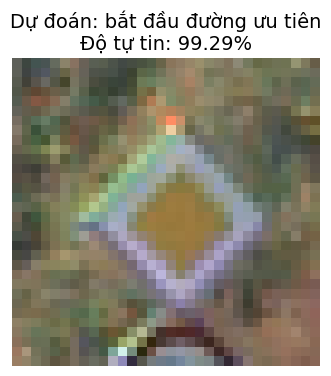

    -> KẾT QUẢ: bắt đầu đường ưu tiên (Độ tự tin: 99.29%)

Đang dự đoán ảnh: test4.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test4.png
+--------------------------------------------------------------------


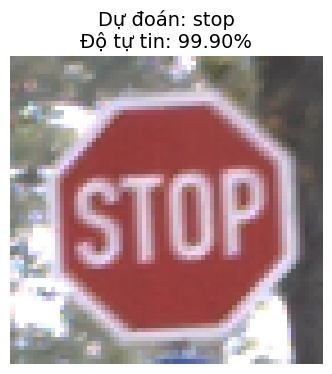

    -> KẾT QUẢ: stop (Độ tự tin: 99.90%)

Đang dự đoán ảnh: test2.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test2.png
+--------------------------------------------------------------------


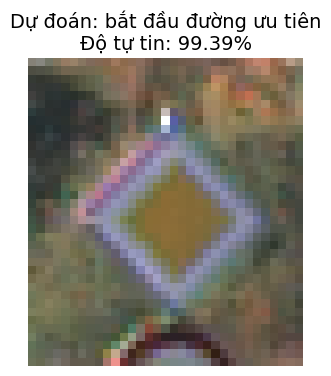

    -> KẾT QUẢ: bắt đầu đường ưu tiên (Độ tự tin: 99.39%)

Đang dự đoán ảnh: test6.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test6.png
+--------------------------------------------------------------------


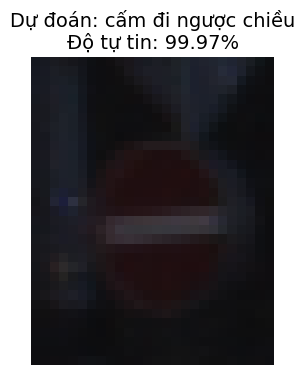

    -> KẾT QUẢ: cấm đi ngược chiều (Độ tự tin: 99.97%)

Đang dự đoán ảnh: test9.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test9.png
+--------------------------------------------------------------------


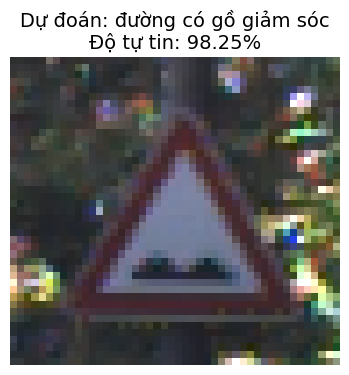

    -> KẾT QUẢ: đường có gồ giảm sóc (Độ tự tin: 98.25%)

Đang dự đoán ảnh: test3.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test3.png
+--------------------------------------------------------------------


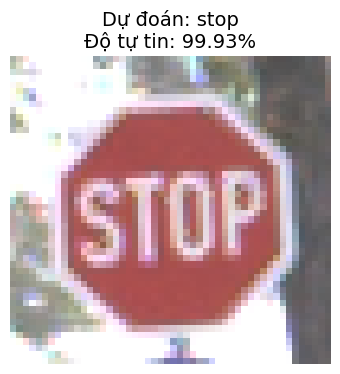

    -> KẾT QUẢ: stop (Độ tự tin: 99.93%)

Đang dự đoán ảnh: test7.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test7.png
+--------------------------------------------------------------------


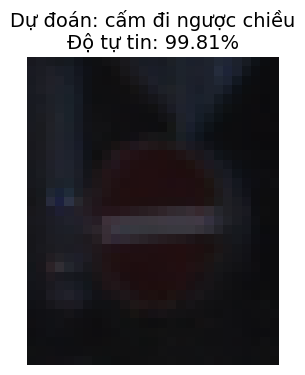

    -> KẾT QUẢ: cấm đi ngược chiều (Độ tự tin: 99.81%)

Đang dự đoán ảnh: test1.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test1.png
+--------------------------------------------------------------------


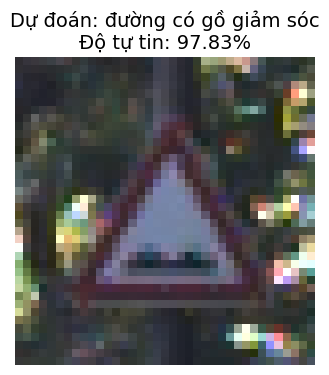

    -> KẾT QUẢ: đường có gồ giảm sóc (Độ tự tin: 97.83%)

Đang dự đoán ảnh: test5.png
Đường dẫn: /content/drive/MyDrive/Colab Notebooks/data_example/test5.png
+--------------------------------------------------------------------


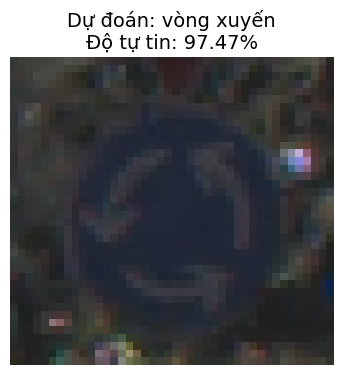

    -> KẾT QUẢ: vòng xuyến (Độ tự tin: 97.47%)

--- HOÀN TẤT DỰ ĐOÁN TOÀN BỘ THƯ MỤC ---


In [24]:
import glob
import os

#  CODE ĐỂ DỰ ĐOÁN TẤT CẢ ẢNH TRONG THƯ MỤC

test_directory = "/content/drive/MyDrive/Colab Notebooks/data_example/"
print(f"--- BẮT ĐẦU QUÉT THƯ MỤC: {test_directory} ---")

# 2. Tìm tất cả các file ảnh (png, jpg, jpeg)
png_files = glob.glob(os.path.join(test_directory, '*.png'))
jpg_files = glob.glob(os.path.join(test_directory, '*.jpg'))
jpeg_files = glob.glob(os.path.join(test_directory, '*.jpeg'))

all_test_images = png_files + jpg_files + jpeg_files

# 3. Kiểm tra xem có tìm thấy ảnh nào không
if not all_test_images:
    print(f"LỖI: Không tìm thấy file ảnh .png, .jpg, hoặc .jpeg nào trong thư mục trên.")
else:
    print(f"Tìm thấy tổng cộng {len(all_test_images)} ảnh. Bắt đầu dự đoán...")

    # 4. Lặp qua từng file ảnh và gọi hàm dự đoán
    for image_file_path in all_test_images:
        print(f"\n" + "="*70)
        print(f"Đang dự đoán ảnh: {os.path.basename(image_file_path)}")
        print(f"Đường dẫn: {image_file_path}")
        print(f"+" + "-"*68)

        try:
            predicted_label, score = predict_new_image(
                image_file_path,
                model_path='best_traffic_sign_model.pkl'
            )

            if predicted_label:
                print(f"    -> KẾT QUẢ: {predicted_label} (Độ tự tin: {score*100:.2f}%)")

        except Exception as e:
            print(f"    LỖI KHI XỬ LÝ FILE {image_file_path}: {e}")

print("\n--- HOÀN TẤT DỰ ĐOÁN TOÀN BỘ THƯ MỤC ---")